## Hockey Dataset Analysis

In [11]:
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import glob
import os
from PIL import Image
from pathlib import Path
import json
from sklearn.model_selection import train_test_split

%matplotlib inline

In [12]:
dataset_dir = "./hockey_dataset"

### Classes

In [13]:
CATEGORY_TO_IDX = {"No_penalty": 0, "Slashing": 1, "Tripping": 2}

IDX_TO_CATEGORY = {0: "No_penalty", 1: "Slashing", 2: "Tripping"}

In [14]:
all_video_dirs = glob.glob(os.path.join(dataset_dir, "*", "*"))
penalty_idxs = [
    CATEGORY_TO_IDX[os.path.basename(Path(x).parents[0])] for x in all_video_dirs
]
X_tv_dirs, X_test_dirs, y_tv, y_test = train_test_split(
    all_video_dirs, penalty_idxs, test_size=0.1, random_state=42, stratify=penalty_idxs
)
X_train_dirs, X_val_dirs, y_train, y_val = train_test_split(
    X_tv_dirs, y_tv, test_size=0.18, random_state=42, stratify=y_tv
)

### Data Split Statistics

In [15]:
print("*" * 70)
print("Distribution of Train Split")
print("*" * 70)

train_dict = {}
for imgd in X_train_dirs:
    cat = os.path.basename(Path(imgd).parents[0])
    train_dict[cat] = train_dict.setdefault(cat, 0) + 1
print(train_dict)

total = 0
for idx, (key, val) in enumerate(train_dict.items()):
    print(f"{idx+1}) {key} : {val}")
    total += val

print(f"total : {total}")

**********************************************************************
Distribution of Train Split
**********************************************************************
{'No_penalty': 216, 'Tripping': 177, 'Slashing': 168}
1) No_penalty : 216
2) Tripping : 177
3) Slashing : 168
total : 561


In [16]:
print("*" * 70)
print("Distribution of Val Split")
print("*" * 70)

val_dict = {}
for imgd in X_val_dirs:
    cat = os.path.basename(Path(imgd).parents[0])
    val_dict[cat] = val_dict.setdefault(cat, 0) + 1

total = 0
for idx, (key, val) in enumerate(val_dict.items()):
    print(f"{idx+1}) {key} : {val}")
    total += val

print(f"total : {total}")

**********************************************************************
Distribution of Val Split
**********************************************************************
1) No_penalty : 48
2) Slashing : 37
3) Tripping : 39
total : 124


In [17]:
print("*" * 70)
print("Distribution of Test Split")
print("*" * 70)

test_dict = {}
for imgd in X_test_dirs:
    cat = os.path.basename(Path(imgd).parents[0])
    test_dict[cat] = test_dict.setdefault(cat, 0) + 1

total = 0
for idx, (key, val) in enumerate(test_dict.items()):
    print(f"{idx+1}) {key} : {val}")
    total += val

print(f"total : {total}")

**********************************************************************
Distribution of Test Split
**********************************************************************
1) Slashing : 23
2) No_penalty : 30
3) Tripping : 24
total : 77


### Pose Overlay

In [18]:
np.random.seed(42)
COLORS = [
    [255, 172, 0],
    [223, 0, 255],
    [12, 0, 255],
    [0, 255, 178],
    [31, 0, 255],
    [0, 159, 255],
    [255, 95, 0],
    [255, 19, 0],
    [255, 0, 0],
    [255, 38, 0],
    [0, 255, 25],
    [255, 0, 133],
    [0, 82, 255],
]
BODY_PAIRS = [
    [0, 1],
    [1, 2],
    [1, 8],
    [1, 11],
    [1, 5],
    [2, 3],
    [3, 4],
    [5, 6],
    [6, 7],
    [8, 9],
    [9, 10],
    [11, 12],
    [12, 13],
    [14, 15],
]

In [19]:
def plot_poses(action_no):

    random_clip = np.random.choice(
        os.listdir(os.path.join(dataset_dir, IDX_TO_CATEGORY[action_no]))
    )
    frames_path = os.path.join(dataset_dir, IDX_TO_CATEGORY[action_no], random_clip)
    skeleton_path = os.path.join(
        dataset_dir, IDX_TO_CATEGORY[action_no], random_clip, random_clip + ".json"
    )

    #     frames_path = os.path.join(dataset_dir, IDX_TO_CATEGORY[action_no],random_clip)
    #     skeleton_path = os.path.join(
    #         dataset_dir, IDX_TO_CATEGORY[action_no], random_clip, random_clip + ".json"
    #     )

    print(f"skeleton path = {skeleton_path}")

    player_color = {}
    color_idx = 0

    with open(skeleton_path, "r") as f:
        data = json.load(f)

    start = 0
    end = 64

    for frame_no in range(start, end):

        frame_pose = data[frame_no]

        player_poses = [
            (pno, frame_pose[pno]) for pno in frame_pose.keys() if pno.startswith("p")
        ]

        for pno, ppose in player_poses:
            ppose_new = []
            for i in range(0, len(ppose), 3):
                x = ppose[i]
                y = ppose[i + 1]
                c = ppose[i + 2]

                if x <= 2 and y <= 2:
                    ppose_new.extend([0, 0, c])
                else:
                    ppose_new.extend([x, y, c])
            ppose = ppose_new
            if pno not in player_color:
                player_color[pno] = COLORS[color_idx]
                color_idx += 1

            for jidx in range(0, len(ppose), 3):
                x = ppose[jidx]
                y = ppose[jidx + 1]
                c = ppose[jidx + 2]
                if not (x == 0 and y == 0):
                    plt.plot(x, y, marker="o", color=np.array(player_color[pno]) / 255)
            for j1, j2 in BODY_PAIRS:
                x1 = ppose[3 * j1]
                x2 = ppose[3 * j2]
                y1 = ppose[3 * j1 + 1]
                y2 = ppose[3 * j2 + 1]
                if not (x1 == 0 and y1 == 0) and not (x2 == 0 and y2 == 0):
                    plt.plot(
                        (x1, x2), (y1, y2), color=np.array(player_color[pno]) / 255
                    )

        frame_name = "frame_%04d.png" % int(frame_no)
        img_path = os.path.join(
            dataset_dir, IDX_TO_CATEGORY[action_no], random_clip, frame_name
        )
        img = np.array(plt.imread(img_path))
        plt.imshow(img, origin="upper")
        plt.title(frame_name)
        plt.pause(0.1)
        plt.clf()

skeleton path = ./hockey_dataset/Tripping/_2018-02-13-ana-det-home137/_2018-02-13-ana-det-home137.json


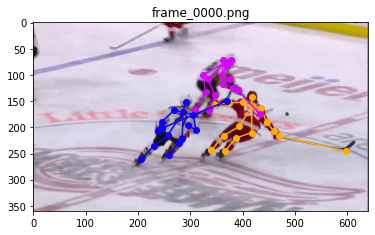

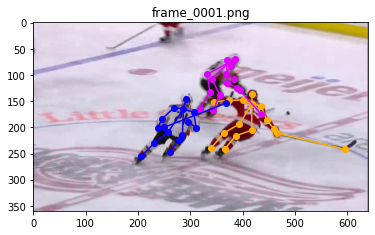

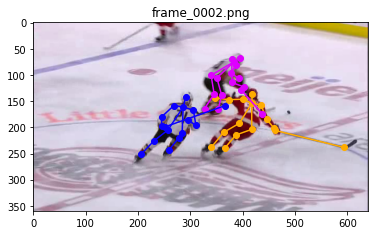

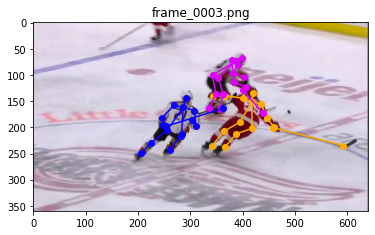

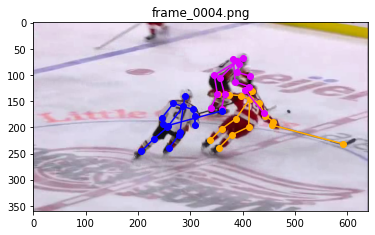

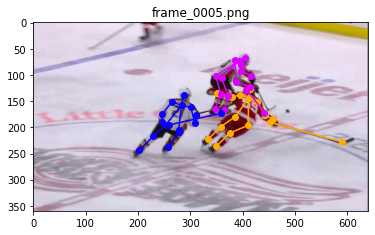

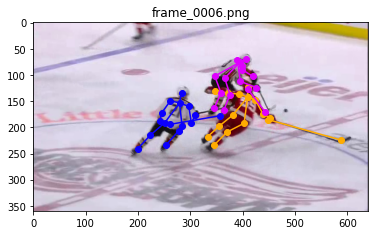

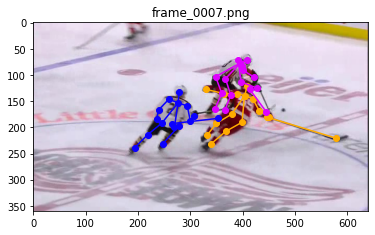

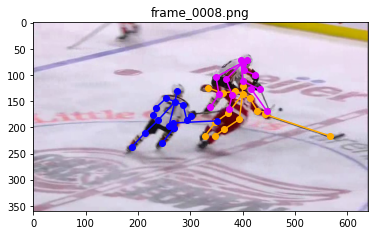

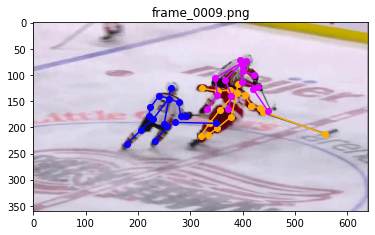

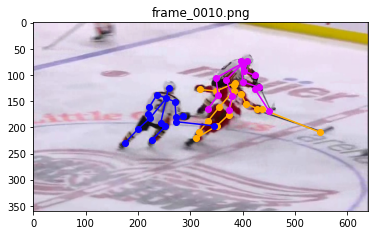

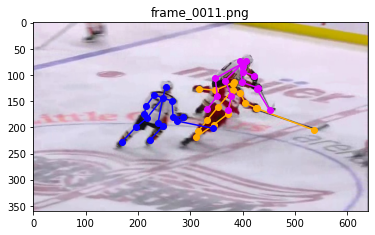

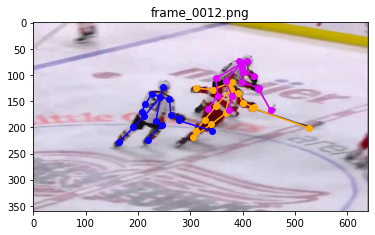

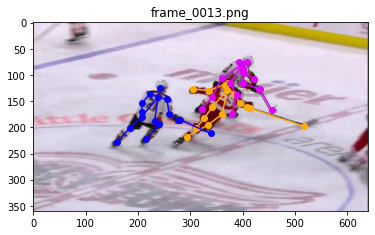

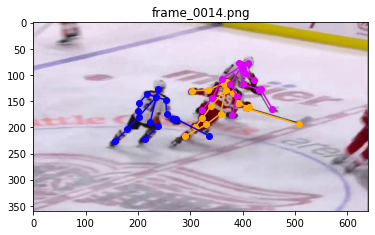

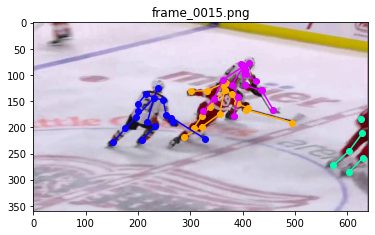

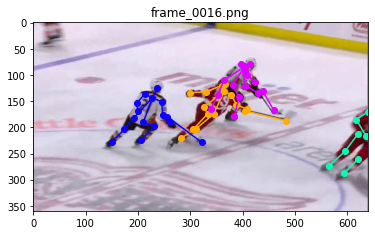

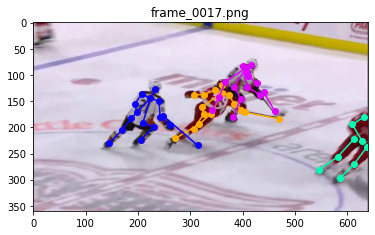

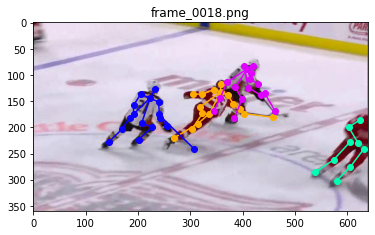

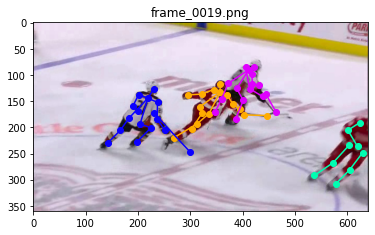

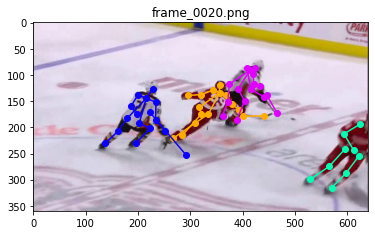

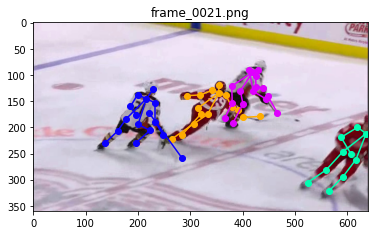

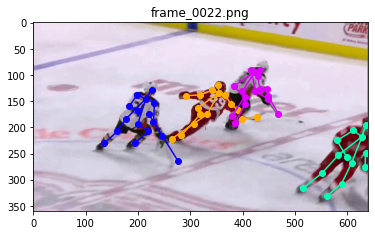

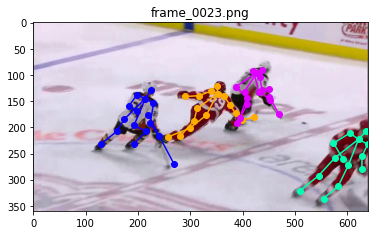

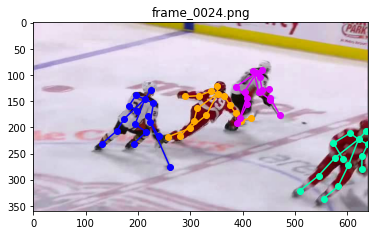

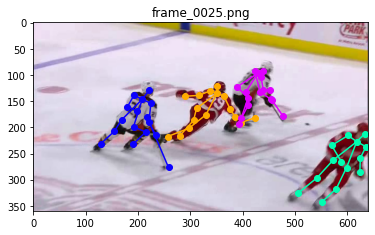

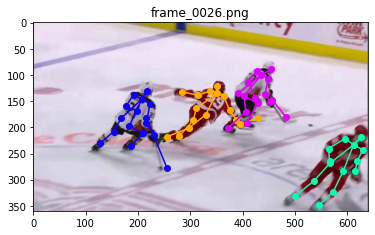

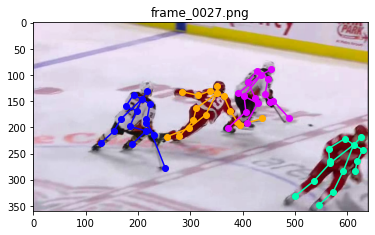

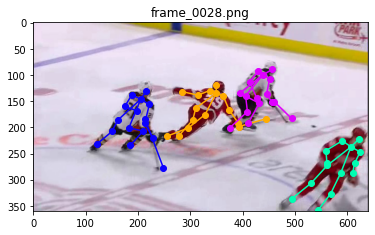

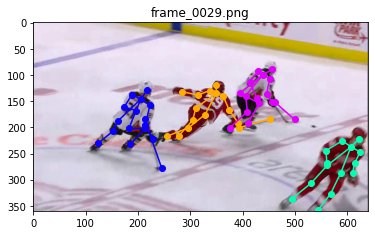

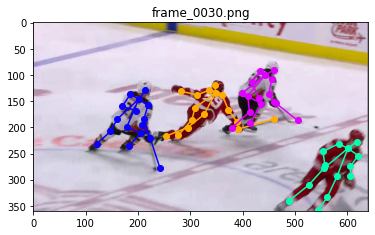

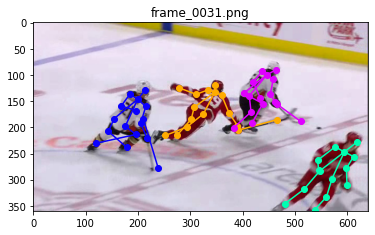

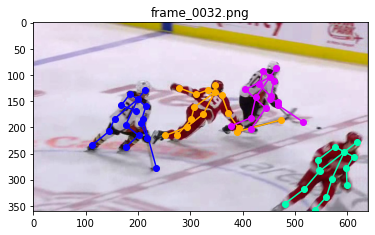

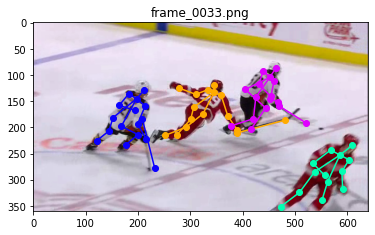

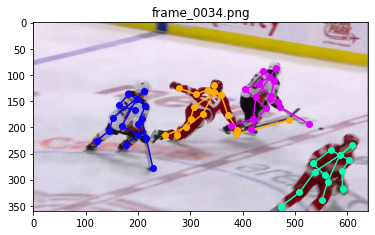

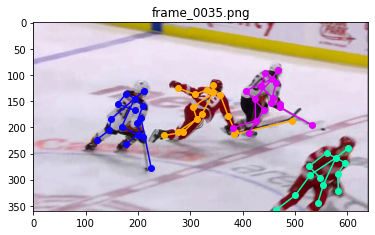

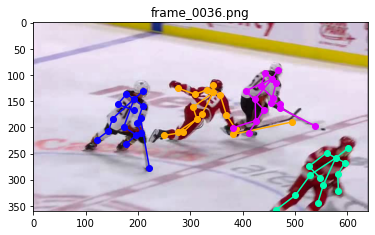

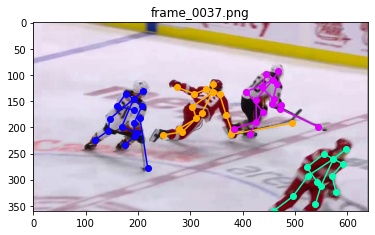

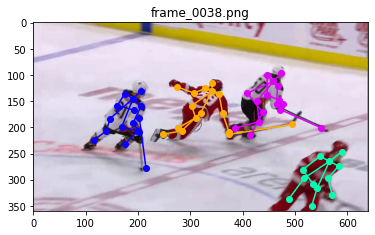

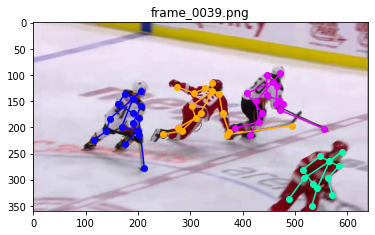

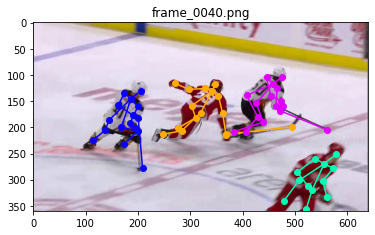

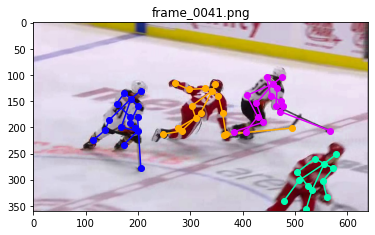

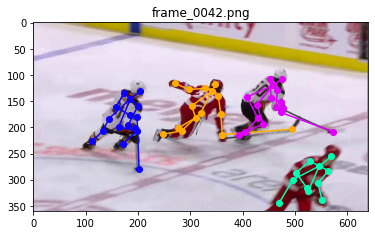

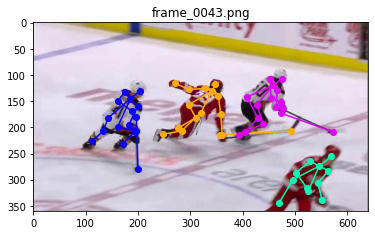

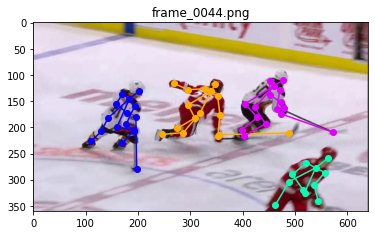

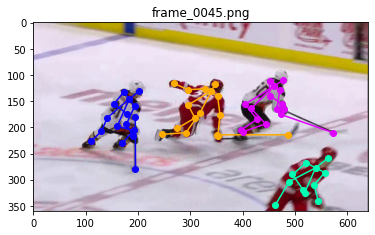

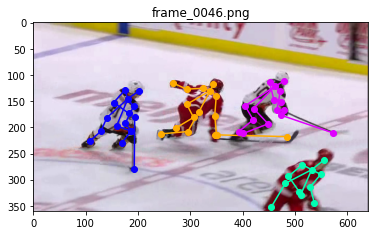

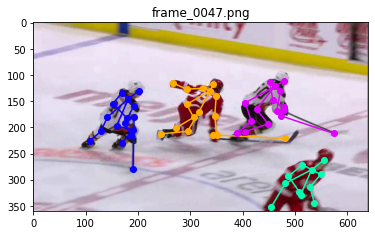

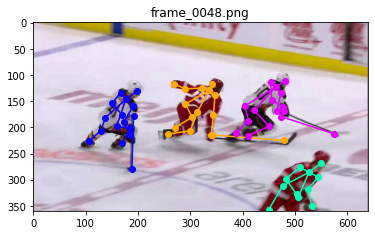

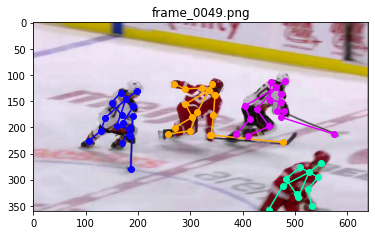

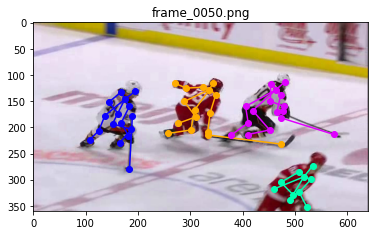

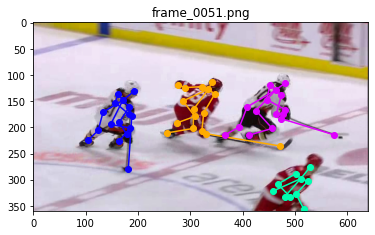

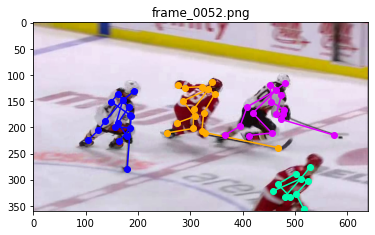

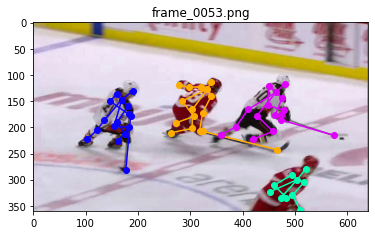

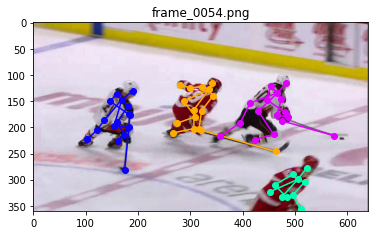

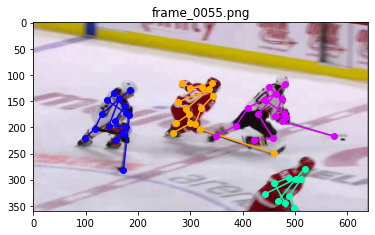

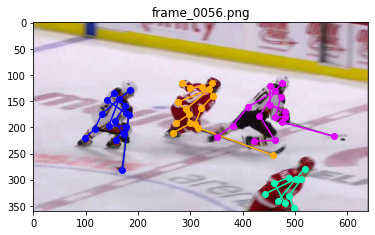

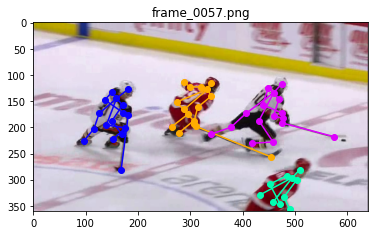

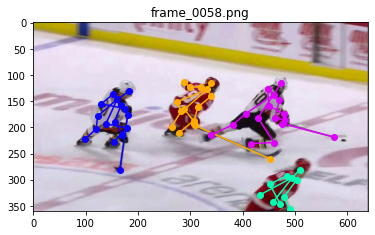

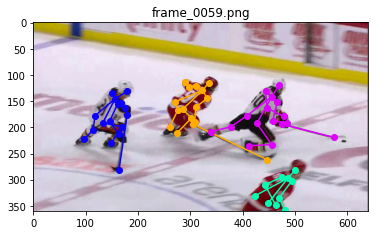

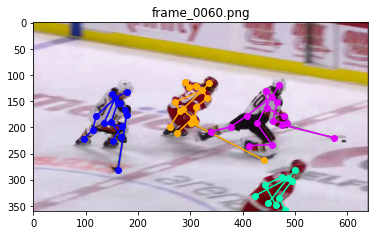

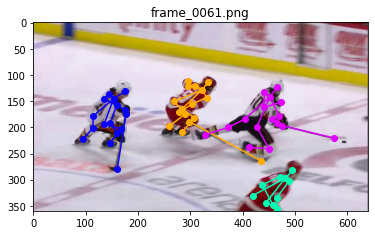

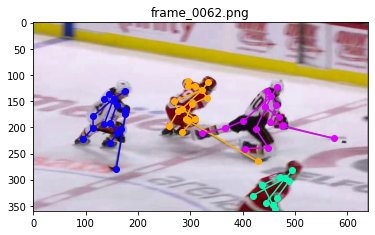

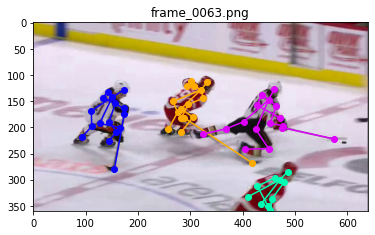

<Figure size 432x288 with 0 Axes>

In [20]:
action_no = 2

plot_poses(action_no)